In [1]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import tensorflow as tf
import os
from nengo.dists import Choice
from datetime import datetime
# from nengo_extras.data import load_mnist
import pickle
from nengo.utils.matplotlib import rasterplot

import time

from InputData import PresentInputWithPause

# from nengo_extras.graphviz import net_diagram

from nengo.neurons import LIFRate

from nengo.params import Parameter, NumberParam, FrozenObject
from nengo.dists import Choice, Distribution, get_samples, Uniform

from nengo.utils.numpy import clip, is_array_like
from utilis import *
import keras

from args_mnist import args as my_args
import itertools
import random
import logging

In [2]:
(image_train, label_train), (image_test, label_test) = (keras.datasets.mnist.load_data())

In [3]:
input_nbr = 1

In [4]:
image_train_filtered = []
label_train_filtered = []
for i in range(0,input_nbr):
      
    image_train_filtered.append(image_train[i])
    label_train_filtered.append(label_train[i])

image_train_filtered = np.array(image_train_filtered)
label_train_filtered = np.array(label_train_filtered)

image_train_filtered = image_train_filtered/255

In [5]:
input_neurons_args = {
        "n_neurons":784,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([3]),
        "bias":nengo.dists.Choice([0.6]),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1.8, amplitude=1,tau_ref=0.002)
}

#Layer 1 parameters
layer_1_neurons_args = {
        "n_neurons":10,
        "dimensions":1,
        "label":"Layer 1",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([2]),
        "bias":nengo.dists.Choice([0]),
        # "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.5), seed=1), 
        "neuron_type":STDPLIF(tau_rc=0.06, min_voltage=-1, spiking_threshold=1, inhibition_time=10,tau_ref=0.002)
}
presentation_time = 0.20
pause_time = 0


learning_args = {
        "lr": 1,
        "winit_min":0.5,
        "winit_max":1,
        "vprog":0, 
        "vthp":0.5,
        "vthn":0.5,
        "vprog_increment":0,
        "voltage_clip_max":1.8,
        "voltage_clip_min":-1.8,
        "Vapp_multiplier":1,
}

In [6]:
model = nengo.Network("My network", seed = 1)
    #############################
    # Model construction
    #############################
with model:
    # picture = nengo.Node(PresentInputWithPause(images, presentation_time, pause_time,0))
    picture = nengo.Node(nengo.processes.PresentInput(image_train_filtered, presentation_time=presentation_time))
    true_label = nengo.Node(nengo.processes.PresentInput(label_train_filtered, presentation_time=presentation_time))
    # true_label = nengo.Node(PresentInputWithPause(labels, presentation_time, pause_time,-1))

    # input layer  
    input_layer = nengo.Ensemble(**input_neurons_args)
    input_conn = nengo.Connection(picture,input_layer.neurons,synapse=None)

    #first layer
    layer1 = nengo.Ensemble(**layer_1_neurons_args)

    #Weights between input layer and layer 1
    w = nengo.Node(CustomRule_post_v2_tio2(**learning_args), size_in=784, size_out=10)
    nengo.Connection(input_layer.neurons, w, synapse=None)
    nengo.Connection(w, layer1.neurons, synapse=None)

    #Probes
    # p_true_label = nengo.Probe(true_label, sample_every=probe_sample_rate)
    p_input_layer = nengo.Probe(input_layer.neurons)
    p_layer_1 = nengo.Probe(layer1.neurons)
    
    p_input_layer_v = nengo.Probe(input_layer.neurons, 'voltage')
    p_layer1_v = nengo.Probe(layer1.neurons, 'voltage')
    # weights_probe = nengo.Probe(conn1,"weights",sample_every=probe_sample_rate)

#         weights = w.output.history

        

    # with nengo_ocl.Simulator(model) as sim :   
with nengo.Simulator(model, dt=0.005, optimize=True) as sim:

        
    w.output.set_signal_vmem(sim.signals[sim.model.sig[input_layer.neurons]["voltage"]])
    w.output.set_signal_out(sim.signals[sim.model.sig[layer1.neurons]["out"]])


    sim.run((presentation_time+pause_time) * label_train_filtered.shape[0])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

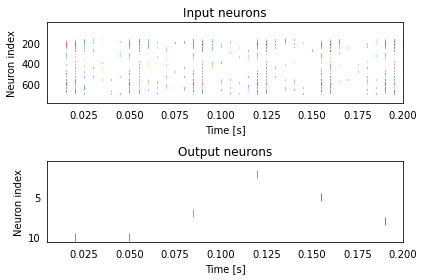

In [94]:
plt.subplot(2, 1, 1)
plt.title('Input neurons')
rasterplot(sim.trange(), sim.data[p_input_layer])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

plt.subplot(2, 1, 2)
plt.title('Output neurons')
rasterplot(sim.trange(), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

plt.tight_layout()
plt.savefig("raster.svg")

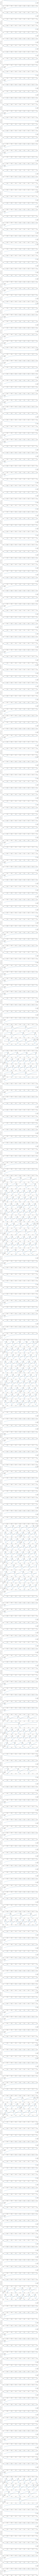

In [95]:
fig, axes = plt.subplots(392, 1, figsize=(12,784))

for i in range(392):
    axes[i].plot(sim.trange(), sim.data[p_input_layer_v][:,i], label='v_mem')
    axes[i].plot(sim.trange(), sim.data[p_input_layer][:,i] /100, label='spikes', c='k')
    axes[i].set_ylabel("Neuron index: " + str(i+1))
    axes[i].legend()

plt.tight_layout()    
plt.savefig('input_membrane_spikes.svg')
plt.savefig('input_membrane_spikes.png')

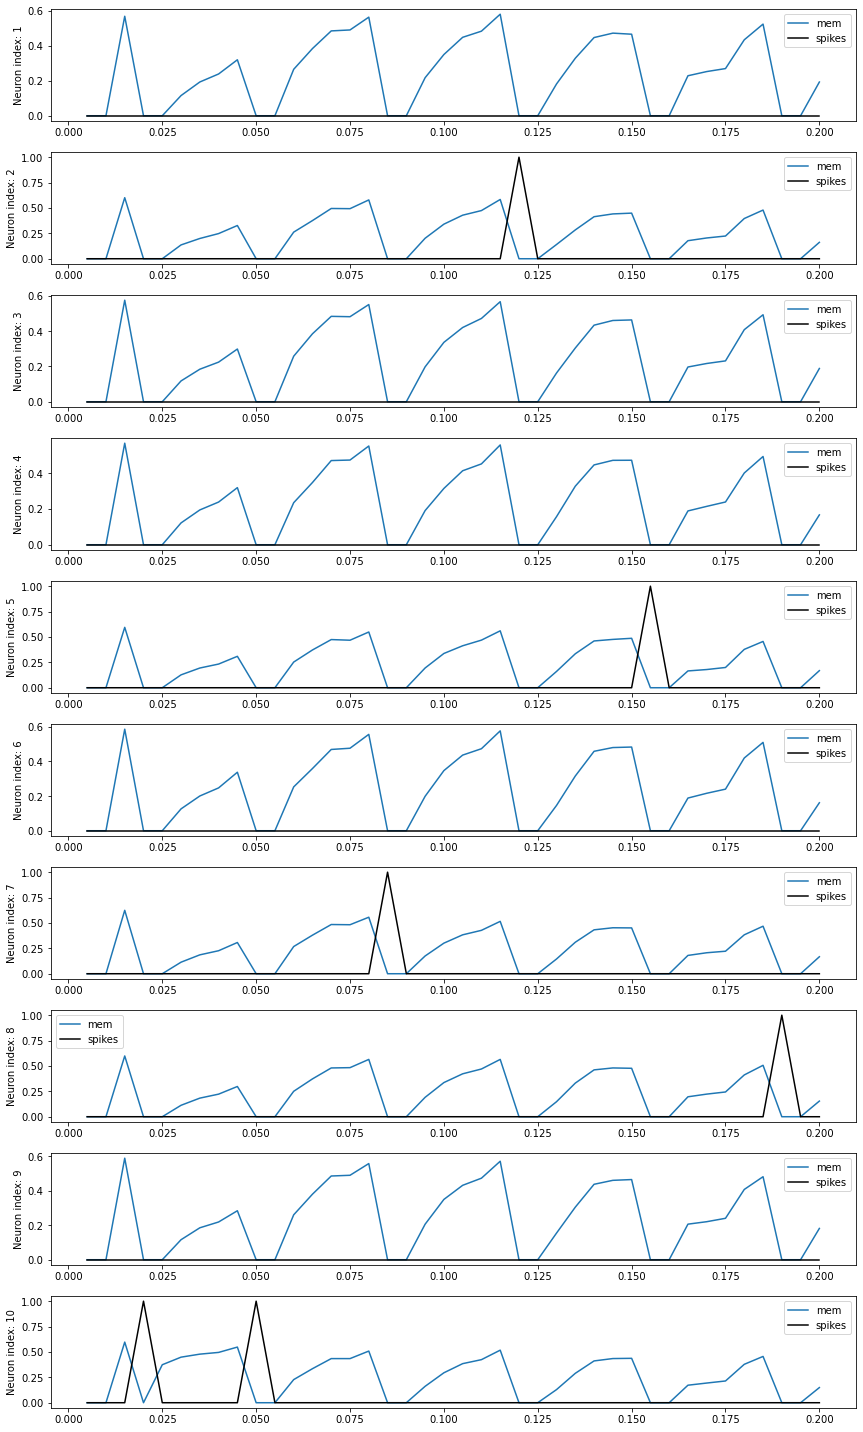

In [96]:
fig, axes = plt.subplots(10, 1, figsize=(12,20))

for i in range(10):
    axes[i].plot(sim.trange(), sim.data[p_layer1_v][:,i], label='mem')
    axes[i].plot(sim.trange(), sim.data[p_layer_1][:,i] /200, label='spikes', c='k')
    axes[i].set_ylabel("Neuron index: " + str(i+1))
    axes[i].legend()
    
plt.tight_layout()    
plt.savefig('output_membrane_spikes.svg')
plt.savefig('output_membrane_spikes.png')

# Neuron characterization

In [5]:
neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([4]),
        "bias":nengo.dists.Choice([0.5]),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1, amplitude=1,tau_ref=0.005)
}

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

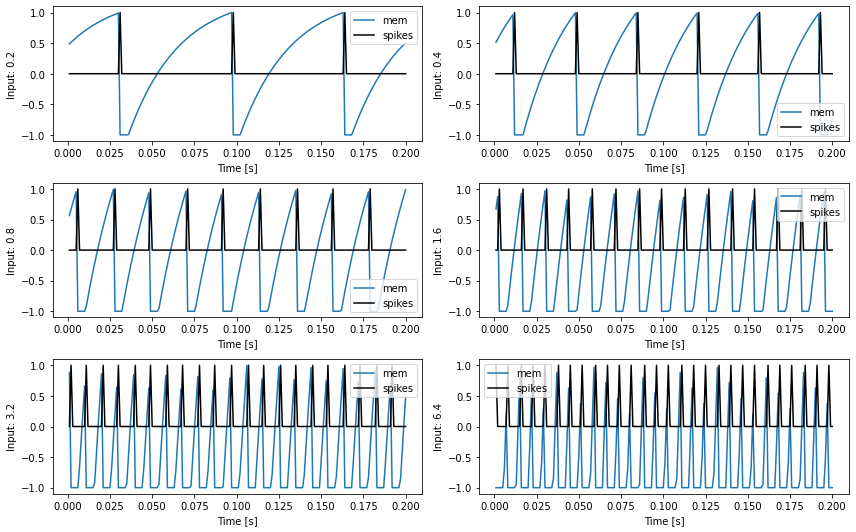

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(12,7.5))

for i in range (6):
    
    model = nengo.Network("My network", seed = 1)
        #############################
        # Model construction
        #############################
    with model:

        stim = nengo.Node([2**(i+1) /10])

        neuron_layer = nengo.Ensemble(**neurons_args)
        input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

        p_neuron_layer = nengo.Probe(neuron_layer.neurons)
        p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

    with nengo.Simulator(model, dt=0.001, optimize=True) as sim:

        sim.run(0.2)
    a = int(i/2)
    b = int(i%2)
    axes[a][b].set_ylabel("Input: " + str(2**(i+1) /10))
    axes[a][b].set_xlabel("Time [s]")
    axes[a][b].plot(sim.trange(), sim.data[p_neuron_layer_v], label='mem')
    axes[a][b].plot(sim.trange(), sim.data[p_neuron_layer] /1000, label='spikes', c='k')
    axes[a][b].legend()

plt.tight_layout()  
plt.savefig('neuron_character.svg')
plt.savefig('neuron_character.png')

In [7]:
'''
0.2: 19 Hz
0.4: 30 Hz
0.8: 48 Hz
1.6: 75 Hz
3.2: 105 Hz
6.4: 150 Hz
'''

neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([4]),
        "bias":nengo.dists.Choice([0.5]),
#         "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.1), seed=100),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1, amplitude=1,tau_ref=0.005)
}

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

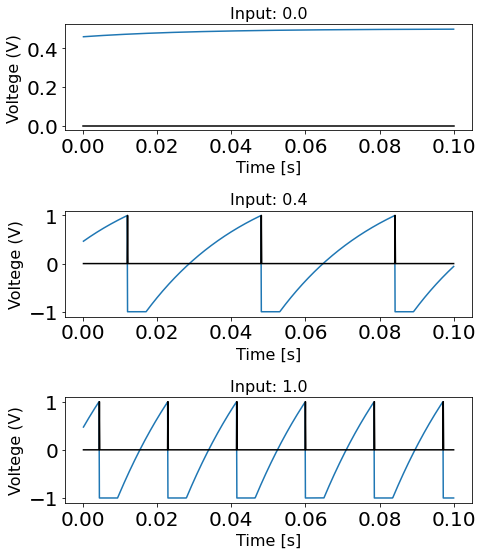

In [10]:
import matplotlib as mpl
fig, axes = plt.subplots(3, 1, figsize=(7,8))
mpl.rcParams.update({'font.size': 16})


for i in [0,2,5]:
    
    model = nengo.Network("My network", seed = 1)
        #############################
        # Model construction
        #############################
    with model:

        stim = nengo.Node([i*2/10])

        neuron_layer = nengo.Ensemble(**neurons_args)
        input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

        p_neuron_layer = nengo.Probe(neuron_layer.neurons)
        p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

    with nengo.Simulator(model, dt=0.0001, optimize=True) as sim:

        sim.run(0.1)
    a = int(i/2)
    b = int(i%2)
    axes[a].set_title("Input: " + str(i*2/10), fontsize=16)
    axes[a].set_xlabel("Time [s]", fontsize=16)
    axes[a].set_ylabel("Voltege (V)", fontsize=16)
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer_v], label='Membrane potential')
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer] /10000, label='Spikes', c='k')
#     axes[a].legend()

plt.tight_layout()  
plt.savefig('neuron_character_no_noise.svg')
plt.savefig('neuron_character_no_noise.png')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

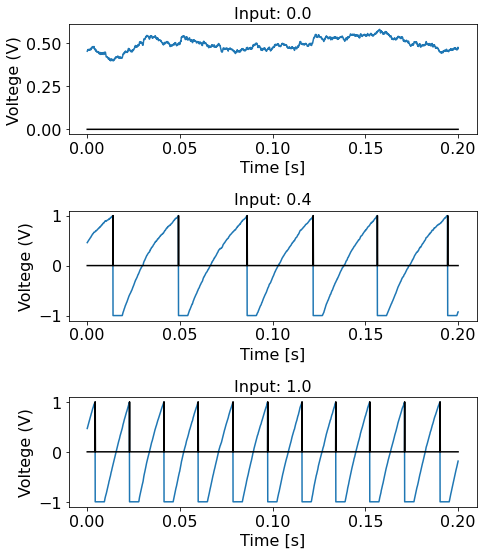

In [12]:
neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([4]),
        "bias":nengo.dists.Choice([0.5]),
        "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.01), seed=100),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1, amplitude=1,tau_ref=0.005)
}


import matplotlib as mpl
fig, axes = plt.subplots(3, 1, figsize=(7,8))
mpl.rcParams.update({'font.size': 16})


for i in [0,2,5]:
    
    model = nengo.Network("My network", seed = 1)
        #############################
        # Model construction
        #############################
    with model:

        stim = nengo.Node([i*2/10])

        neuron_layer = nengo.Ensemble(**neurons_args)
        input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

        p_neuron_layer = nengo.Probe(neuron_layer.neurons)
        p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

    with nengo.Simulator(model, dt=0.0001, optimize=True) as sim:

        sim.run(0.2)
    a = int(i/2)
    b = int(i%2)
    axes[a].set_title("Input: " + str(i*2/10), fontsize=16)
    axes[a].set_xlabel("Time [s]", fontsize=16)
    axes[a].set_ylabel("Voltege (V)", fontsize=16)
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer_v], label='Voltage')
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer] /10000, label='Spikes', c='k')
#     axes[a].legend()

plt.tight_layout()  
plt.savefig('neuron_character_low_noise.svg')
plt.savefig('neuron_character_low_noise.png')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

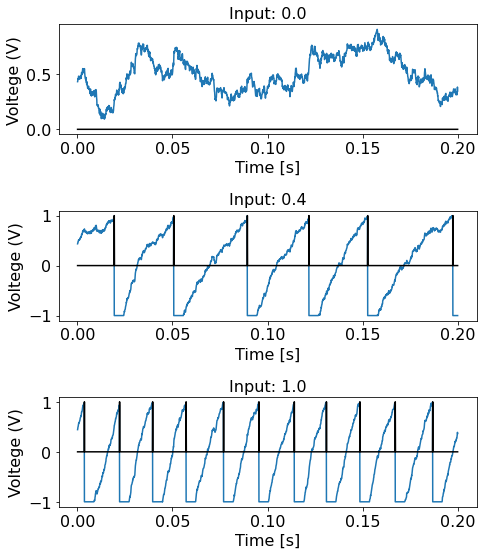

In [13]:
neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([4]),
        "bias":nengo.dists.Choice([0.5]),
        "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.05), seed=100),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1, amplitude=1,tau_ref=0.005)
}


import matplotlib as mpl
fig, axes = plt.subplots(3, 1, figsize=(7,8))
mpl.rcParams.update({'font.size': 16})


for i in [0,2,5]:
    
    model = nengo.Network("My network", seed = 1)
        #############################
        # Model construction
        #############################
    with model:

        stim = nengo.Node([i*2/10])

        neuron_layer = nengo.Ensemble(**neurons_args)
        input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

        p_neuron_layer = nengo.Probe(neuron_layer.neurons)
        p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

    with nengo.Simulator(model, dt=0.0001, optimize=True) as sim:

        sim.run(0.2)
    a = int(i/2)
    b = int(i%2)
    axes[a].set_title("Input: " + str(i*2/10), fontsize=16)
    axes[a].set_xlabel("Time [s]", fontsize=16)
    axes[a].set_ylabel("Voltege (V)", fontsize=16)
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer_v], label='Voltage')
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer] /10000, label='Spikes', c='k')
#     axes[a].legend()

plt.tight_layout()  
plt.savefig('neuron_character_mid_noise.svg')
plt.savefig('neuron_character_mid_noise.png')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

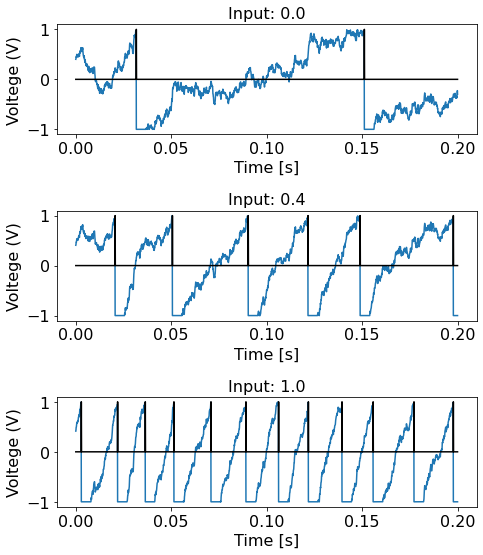

In [14]:
neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([4]),
        "bias":nengo.dists.Choice([0.5]),
        "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.1), seed=100),
        "neuron_type":MyLIF_in_v2(tau_rc=0.03,min_voltage=-1, amplitude=1,tau_ref=0.005)
}


import matplotlib as mpl
fig, axes = plt.subplots(3, 1, figsize=(7,8))
mpl.rcParams.update({'font.size': 16})


for i in [0,2,5]:
    
    model = nengo.Network("My network", seed = 1)
        #############################
        # Model construction
        #############################
    with model:

        stim = nengo.Node([i*2/10])

        neuron_layer = nengo.Ensemble(**neurons_args)
        input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

        p_neuron_layer = nengo.Probe(neuron_layer.neurons)
        p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

    with nengo.Simulator(model, dt=0.0001, optimize=True) as sim:

        sim.run(0.2)
    a = int(i/2)
    b = int(i%2)
    axes[a].set_title("Input: " + str(i*2/10), fontsize=16)
    axes[a].set_xlabel("Time [s]", fontsize=16)
    axes[a].set_ylabel("Voltege (V)", fontsize=16)
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer_v], label='Voltage')
    axes[a].plot(sim.trange(), sim.data[p_neuron_layer] /10000, label='Spikes', c='k')
#     axes[a].legend()

plt.tight_layout()  
plt.savefig('neuron_character_high_noise.svg')
plt.savefig('neuron_character_high_noise.png')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

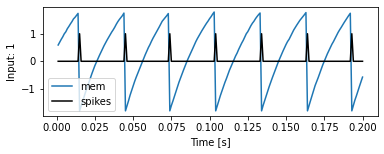

In [45]:
neurons_args = {
        "n_neurons":1,
        "dimensions":1,
        "label":"Input layer",
        "encoders":nengo.dists.Choice([[1]]),
        "gain":nengo.dists.Choice([3]),
        "bias":nengo.dists.Choice([0]),
        "noise":nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0.03, 0.01), seed=1),
        "neuron_type":MyLIF_in(tau_rc=0.03,min_voltage=-1.8, amplitude=1,tau_ref=0.002)
}

model = nengo.Network("My network", seed = 1)
#############################
# Model construction
#############################
with model:

    stim = nengo.Node([1])

    neuron_layer = nengo.Ensemble(**neurons_args)
    input_conn = nengo.Connection(stim,neuron_layer.neurons,synapse=None)

    p_neuron_layer = nengo.Probe(neuron_layer.neurons)
    p_neuron_layer_v = nengo.Probe(neuron_layer.neurons, 'voltage')

with nengo.Simulator(model, dt=0.001, optimize=True) as sim:

    sim.run(0.2)
fig, axes = plt.subplots(1, 1, figsize=(6,2))
axes.set_ylabel("Input: " + str(1))
axes.set_xlabel("Time [s]")
axes.plot(sim.trange(), sim.data[p_neuron_layer_v], label='mem')
axes.plot(sim.trange(), sim.data[p_neuron_layer] /1000, label='spikes', c='k')
axes.legend()
